# Overview

Impute all your features.

In [83]:
import os
import re
import tempfile
import textwrap
import warnings

import japanize_matplotlib
import lightgbm as lgb
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from hyperopt import STATUS_OK, SparkTrials, Trials, fmin, hp, tpe
from hyperopt.pyll.base import scope
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImblearnPipeline
from lightgbm import LGBMClassifier
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import ColSpec, Schema
from pyspark.sql import SparkSession
from scipy.stats import chi2_contingency
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE, RFECV, SelectKBest, chi2
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    auc,
    confusion_matrix,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

from JapanHorseRaceAnalytics.utilities.base import get_base_dir, read_hive_table
from JapanHorseRaceAnalytics.utilities.metrics import (
    calculate_binary_classifier_statistics,
)
from JapanHorseRaceAnalytics.utilities.mlflow import get_colspecs
from JapanHorseRaceAnalytics.utilities.structured_logger import logger

# Set pandas display options
pd.set_option("display.max_rows", 1050)
pd.set_option("display.max_columns", 200)

# Set seed for reproducibility
os.environ["PYTHONHASHSEED"] = str(42)
np.random.seed(42)
tf.random.set_seed(42)
random_state = 42


def chi2_test(df, col1, col2):
    contingency_table = pd.crosstab(df[col1], df[col2])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"chi2: {chi2}, p: {p}, dof: {dof}")

    categories = contingency_table.index
    fig, ax = plt.subplots(figsize=(6, 4))

    ind = np.arange(len(categories))
    width = 0.35

    ax.bar(
        ind - width / 2,
        contingency_table.values[:, 0],
        width,
        label="Observed Yes",
        color="skyblue",
    )
    ax.bar(ind + width / 2, expected[:, 0], width, label="Expected Yes", color="orange")

    description = """
    "Observed Yes" represents the actual counts of the event happening for each category,
    while the "Expected Yes" bars show the counts we would expect if there was no association
    between the two variables. The size of the "Observed Yes" bars relative to the "Expected
    Yes" bars indicates the strength of the association.
    """
    # wrap the text to 70 characters and then print out the indented text
    description = textwrap.fill(textwrap.dedent(description.strip()), width=70)
    print(description)

    ax.set_xlabel("Categories")
    ax.set_ylabel("Counts")
    ax.set_title("Observed vs Expected Counts")
    ax.set_xticks(ind)
    ax.set_xticklabels(categories)
    ax.legend()

    plt.tight_layout()
    plt.show()

In [2]:
warehouse_dir = f"{get_base_dir()}/spark-warehouse"
postgres_driver_path = f"{get_base_dir()}/jars/postgresql-42.7.1.jar"

spark = (
    SparkSession.builder.appName("20240211_competitors")
    .config("spark.driver.memory", "20g")
    .config("spark.sql.warehouse.dir", warehouse_dir)
    .config("spark.jars", postgres_driver_path)
    .config("spark.executor.extraClassPath", postgres_driver_path)
    .config("spark.driver.extraClassPath", postgres_driver_path)
    .enableHiveSupport()
    .getOrCreate()
)

24/02/26 07:48:05 WARN Utils: Your hostname, Hanks-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.40.105 instead (on interface en0)
24/02/26 07:48:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/02/26 07:48:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
data = read_hive_table(
    table_name="features_20240217_v1",
    schema="jhra_curated",
    spark_session=spark,
    # use_cache=False,
)

# drop from data where cat_トラック種別 == "障害"
data = data[(data["cat_トラック種別"] != "障害")]

# drop from data where meta_int_race_horses_異常区分 != '0'
data = data[(data["meta_int_race_horses_異常区分"] == "0")]

data = data.reset_index(drop=True)
data.head()

{"event": "Read from parquet /Users/hankehly/Projects/JapanHorseRaceAnalytics/data/sql_tables/features_20240217_v1.snappy.parquet to pandas", "level": "info", "timestamp": "2024-02-25T22:48:29.920626Z", "logger": "JapanHorseRaceAnalytics.utilities.base"}


,meta_レースキー,meta_馬番,meta_着順,meta_本賞金,meta_単勝的中,meta_単勝払戻金,meta_複勝的中,meta_複勝払戻金,meta_int_races_レースキー,meta_発走日時,meta_場コード,cat_四半期,cat_距離,cat_事前_馬場状態コード,cat_事前_レース条件_トラック情報_右左,cat_事前_レース条件_トラック情報_内外,cat_事前_レース条件_種別,cat_事前_レース条件_条件,cat_事前_レース条件_記号,cat_事前_レース条件_重量,cat_事前_レース条件_グレード,num_事前_馬場差,num_頭数,cat_トラック種別,cat_馬場状態内,cat_馬場状態中,cat_馬場状態外,num_直線馬場差最内,num_直線馬場差内,num_直線馬場差中,num_直線馬場差外,num_直線馬場差大外,cat_芝種類,cat_草丈,cat_転圧,cat_凍結防止剤,num_中間降水量,meta_int_race_horses_レースキー,meta_int_race_horses_馬番,meta_int_race_horses_血統登録番号,meta_int_race_horses_発走日時,meta_int_race_horses_異常区分,num_事前ＩＤＭ,cat_事前脚質,num_事前単勝オッズ,num_事前複勝オッズ,cat_事前馬体,cat_事前気配コード,cat_事前上昇度,cat_事前クラスコード,num_事前テン指数,num_事前ペース指数,num_事前上がり指数,num_負担重量,num_馬体重,num_馬体重増減,cat_性別,cat_トラック種別瞬発戦好走馬,cat_トラック種別消耗戦好走馬,num_一走前不利,num_二走前不利,num_三走前不利,num_一走前着順,num_二走前着順,num_三走前着順,num_四走前着順,num_五走前着順,num_六走前着順,num_1走前上昇度,num_2走前上昇度,num_3走前上昇度,num_4走前上昇度,num_5走前上昇度,num_騎手指数,num_情報指数,num_オッズ指数,num_パドック指数,num_総合指数,cat_馬具変更情報,cat_脚元情報,cat_見習い区分,cat_オッズ印,cat_パドック印,cat_直前総合印,cat_距離適性,num_ローテーション,num_基準オッズ,num_基準人気順位,num_基準複勝オッズ,num_基準複勝人気順位,num_特定情報◎,num_特定情報○,num_特定情報▲,num_特定情報△,num_特定情報×,num_総合情報◎,num_総合情報○,num_総合情報▲,num_総合情報△,num_総合情報×,...,num_競争相手平均調教師1位完走,num_競争相手調教師1位完走標準偏差,num_競争相手最高調教師トップ3完走,num_競争相手最低調教師トップ3完走,num_競争相手平均調教師トップ3完走,num_競争相手調教師トップ3完走標準偏差,num_競争相手最高調教師1位完走率,num_競争相手最低調教師1位完走率,num_競争相手平均調教師1位完走率,num_競争相手調教師1位完走率標準偏差,num_競争相手最高調教師トップ3完走率,num_競争相手最低調教師トップ3完走率,num_競争相手平均調教師トップ3完走率,num_競争相手調教師トップ3完走率標準偏差,num_競争相手最高調教師場所レース数,num_競争相手最低調教師場所レース数,num_競争相手平均調教師場所レース数,num_競争相手調教師場所レース数標準偏差,num_競争相手最高調教師場所1位完走,num_競争相手最低調教師場所1位完走,num_競争相手平均調教師場所1位完走,num_競争相手調教師場所1位完走標準偏差,num_競争相手最高調教師場所トップ3完走,num_競争相手最低調教師場所トップ3完走,num_競争相手平均調教師場所トップ3完走,num_競争相手調教師場所トップ3完走標準偏差,num_競争相手最高調教師場所1位完走率,num_競争相手最低調教師場所1位完走率,num_競争相手平均調教師場所1位完走率,num_競争相手調教師場所1位完走率標準偏差,num_競争相手最高調教師場所トップ3完走率,num_競争相手最低調教師場所トップ3完走率,num_競争相手平均調教師場所トップ3完走率,num_競争相手調教師場所トップ3完走率標準偏差,num_競争相手最高調教師本賞金累計,num_競争相手最低調教師本賞金累計,num_競争相手平均調教師本賞金累計,num_競争相手調教師本賞金累計標準偏差,num_競争相手最高調教師1位完走平均賞金,num_競争相手最低調教師1位完走平均賞金,num_競争相手平均調教師1位完走平均賞金,num_競争相手調教師1位完走平均賞金標準偏差,num_競争相手最高調教師レース数平均賞金,num_競争相手最低調教師レース数平均賞金,num_競争相手平均調教師レース数平均賞金,num_競争相手調教師レース数平均賞金標準偏差,num_競争相手平均調教師レース数差,num_競争相手平均調教師1位完走差,num_競争相手平均調教師トップ3完走差,num_競争相手平均調教師1位完走率差,num_競争相手平均調教師トップ3完走率差,num_競争相手平均調教師場所レース数差,num_競争相手平均調教師場所1位完走差,num_競争相手平均調教師場所トップ3完走差,num_競争相手平均調教師場所1位完走率差,num_競争相手平均調教師場所トップ3完走率差,num_競争相手平均調教師本賞金累計差,num_競争相手平均調教師1位完走平均賞金差,num_競争相手平均調教師レース数平均賞金差,meta_int_combinations_レースキー,meta_int_combinations_馬番,num_馬騎手レース数,num_馬騎手1位完走,num_馬騎手1位完走率,num_馬騎手トップ3完走,num_馬騎手トップ3完走率,num_馬騎手初二走,num_馬騎手同騎手,num_馬騎手場所レース数,num_馬騎手場所1位完走,num_馬騎手場所1位完走率,num_馬騎手場所トップ3完走,num_馬騎手場所トップ3完走率,num_馬調教師レース数,num_馬調教師1位完走,num_馬調教師1位完走率,num_馬調教師トップ3完走,num_馬調教師トップ3完走率,num_馬調教師初二走,num_馬調教師同調教師,num_馬調教師場所レース数,num_馬調教師場所1位完走,num_馬調教師場所1位完走率,num_馬調教師場所トップ3完走,num_馬調教師場所トップ3完走率,meta_int_race_weather_レースキー,num_temperature,num_precipitation,num_snowfall,num_snow_depth,num_wind_speed,cat_wind_direction,num_solar_radiation,num_local_air_pressure,num_sea_level_air_pressure,num_relative_humidity,num_vapor_pressure,num_dew_point_temperature,cat_weather,num_visibility
0,01011103,04,6.0,0.0,False,0,False,0,01011103,2001-08-04 01:45:00,01,3,1200,20,1,1,12,A3,102,3,None,NaN,16,芝,1,1,1,1,1,0,0,0,None,NaN,False,False,NaN,01011103,04,98102049,2001-08-04 01:45:00,0,36.0,好位差し,11.5,2.9,None,None,3,18,-12.4,-21.1,-10.9,550,476.0,14,牡,True,False,0.0,0.0,0.0,7.0,2.0,7.0,NaN,NaN,NaN,3,3,3,None,None,0.4,0.4,0.0,1.8,38.6,0,0,0,None,4,4,5,4.0,16.8,6,3.4,6,0,0,0,10,0,3,6,8,87,0,...,34.133333,18.575492,204,32,98.066667,44.395896,0.162376,0.027668,0.075334,0.036725,0.403960,0.120735,0.213261,0.076365,47,3,18.733333,12.390677,8,0,2.066667,2.112397,15,0,4.733333,4.464178,0.333333,0.0,0.094180,0.088041,0.5,0.000000,0.207743,0.136352,231606.0,14187.0,65859.266667,53242.331542,1687.439024,567.857143,913.419366,273.792817,458.625743,49.167979,141.408061,101.993179,73.000000,-3.133333,-5.066667,-0.016287,-0.036119,-6.733333,-1.066667,-0.733333,-0.010847,0.12559

In [9]:
df = data.copy()

## cat_事前_レース条件_グレード

```
"1",Ｇ１
"2",Ｇ２
"3",Ｇ３
"4",重賞
"5",特別
"6",Ｌ（リステッド競走）
```

### Insights

* 7 classes including missing value
* NULL is the most frequent class
* Highly independent from 複勝的中
* impute with missing value class
* ordinal encoding

In [109]:
df["cat_事前_レース条件_グレード"] = df["cat_事前_レース条件_グレード"].astype("category")
df["cat_事前_レース条件_グレード"].value_counts(dropna=False)

cat_事前_レース条件_グレード
NaN    781049
5      236210
3       22205
2       11042
1        8555
6        4255
4         183
Name: count, dtype: int64

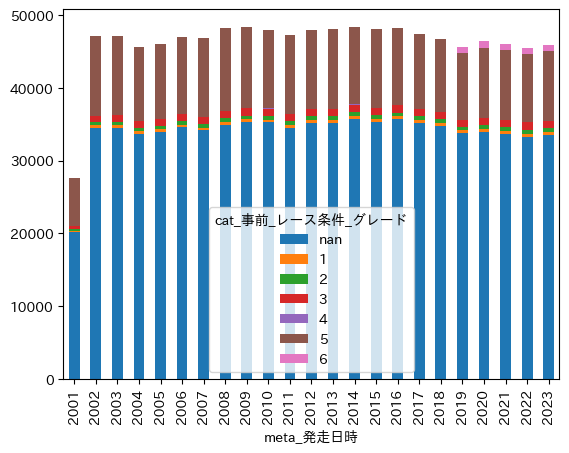

In [102]:
df.groupby(df["meta_発走日時"].dt.year)["cat_事前_レース条件_グレード"].value_counts(
    dropna=False
).unstack().plot(kind="bar", stacked=True);

chi2: 130.05304278921326, p: 2.3190984139914797e-26, dof: 5
"Observed Yes" represents the actual counts of the event happening for
each category,     while the "Expected Yes" bars show the counts we
would expect if there was no association     between the two
variables. The size of the "Observed Yes" bars relative to the
"Expected     Yes" bars indicates the strength of the association.


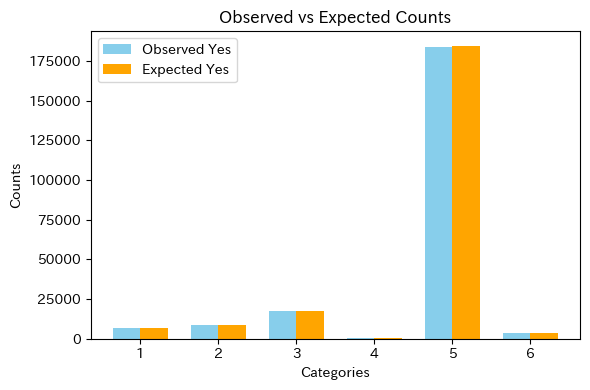

In [103]:
chi2_test(df, "cat_事前_レース条件_グレード", "meta_複勝的中")

In [154]:
imputer = SimpleImputer(strategy="constant", fill_value="N/A")
encoder = OrdinalEncoder(categories=[["1", "2", "3", "4", "5", "6", "N/A"]])
pd.concat(
    [
        df["cat_事前_レース条件_グレード"].rename("original"),
        pd.DataFrame(
            encoder.fit_transform(
                imputer.fit_transform(df[["cat_事前_レース条件_グレード"]])
            ),
            columns=["encoded"],
        ),
    ],
    axis=1,
).value_counts(dropna=False).sort_index()

original  encoded
1         0.0          8555
2         1.0         11042
3         2.0         22205
4         3.0           183
5         4.0        236210
6         5.0          4255
NaN       6.0        781049
Name: count, dtype: int64

In [10]:
pd.concat([df.isna().sum().rename("df"), data.isna().sum().rename("data")], axis=1)

,df,data
meta_レースキー,0,0
meta_馬番,0,0
meta_着順,0,0
meta_本賞金,343,343
meta_単勝的中,0,0
meta_単勝払戻金,0,0
meta_複勝的中,0,0
meta_複勝払戻金,0,0
meta_int_races_レースキー,0,0
meta_発走日時,0,0
